In [1]:
!pip install pydub
!pip install ffmpeg
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=35746116093c25a9a3e12032a74ee84fba4f351085d236c5f45e31ec04f1410d
  Stored in directory: /root/.cache/pip/wheels/30/33/46/5ab7eca55b9490dddbf3441c68a29535996270ef1ce8b9b6d7
Successfully built ffmpeg
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Utils
import pandas as pd
import numpy as np
import json
import os
import subprocess
import zipfile
import IPython.display as ipd
from pathlib import Path
from collections import Counter

# Library for audio processing
import librosa
import soundfile as sf

# Library for silence removal
from pydub import AudioSegment
from pydub.silence import split_on_silence

# Library for noise reduction
import noisereduce as nr

# Visualizations and plots
import matplotlib.pyplot as plt

# Options
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

# Warnings
import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )

# Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In this notebook, we perform three preprocessing steps: silence removal, tracks lenght standardization and noise removal.

# Example

First of all, we want to remove the background noise from the audio track.
To do this, we use the `noisereduce` library.

In [4]:
# Load an example track
audio_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/coughvid_20211012/webm/00291cce-36a0-4a29-9e2d-c1d96ca17242.webm'
original_track, original_sr = librosa.load(audio_path)
ipd.Audio(original_track, rate = original_sr)

In [6]:
# Apply noise reduction
reduced_noise = nr.reduce_noise(y=original_track, sr=original_sr)
sf.write('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/noiseremoval_example.wav', reduced_noise, 22050) # Saving the audio track
ipd.Audio(reduced_noise, rate = original_sr)

Now, we want to remove long periods of silence within the audio tracks, in order to keep only the most relevant audio patterns. To do this, we use the `pydub` library.


In [7]:
### Function for silence removal

# Reading and splitting the audio file into chunks
sound = AudioSegment.from_file('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/noiseremoval_example.wav', format = "wav") 
audio_chunks = split_on_silence(sound,
                                min_silence_len = 1000, # Remove silence longer than 1s
                                silence_thresh = -45,   # What is below -45 dB is considered silence
                                keep_silence = 500)     # Keep 0.5s of silence at the beginning/end

# Putting the file back together
combined = AudioSegment.empty()
for chunk in audio_chunks:
    combined += chunk

# Save the final audio file
combined.export(f'/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/silenceremoval_example.wav', format = "wav")

<_io.BufferedRandom name='/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/silenceremoval_example.wav'>

In [8]:
# Loading track after silence removal
nosilence_track, nosilence_sr = librosa.load('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/silenceremoval_example.wav')
ipd.Audio(nosilence_track, rate = nosilence_sr)

As we can see, the audio track is shorter and contains only coughs.

Last, we want to fix a common lenght between all the tracks. As shown below, we want a fixed length of 6 seconds.

In [13]:
nosilence_track, nosilence_sr = librosa.load('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/silenceremoval_example.wav')
std_audio = librosa.util.fix_length(nosilence_track, size=132300)
sf.write('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/audiopreprocessed_example.wav', std_audio, 22050) # Saving the audio track
ipd.Audio(std_audio, rate = nosilence_sr)

In this case, the track, after silence removal, is already 6 seconds long, so it is not significantly modified.

As a result of this process, we obtain an audio track that is shorter, more clear and where the coughs are highlighted.

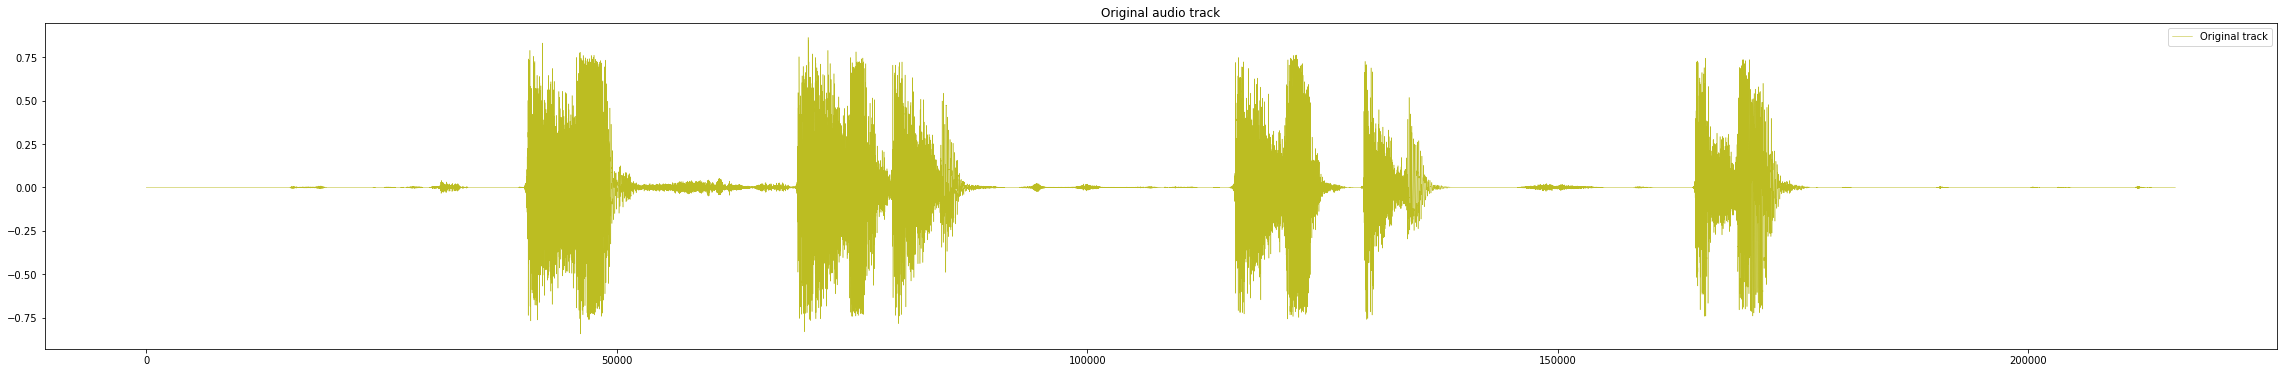

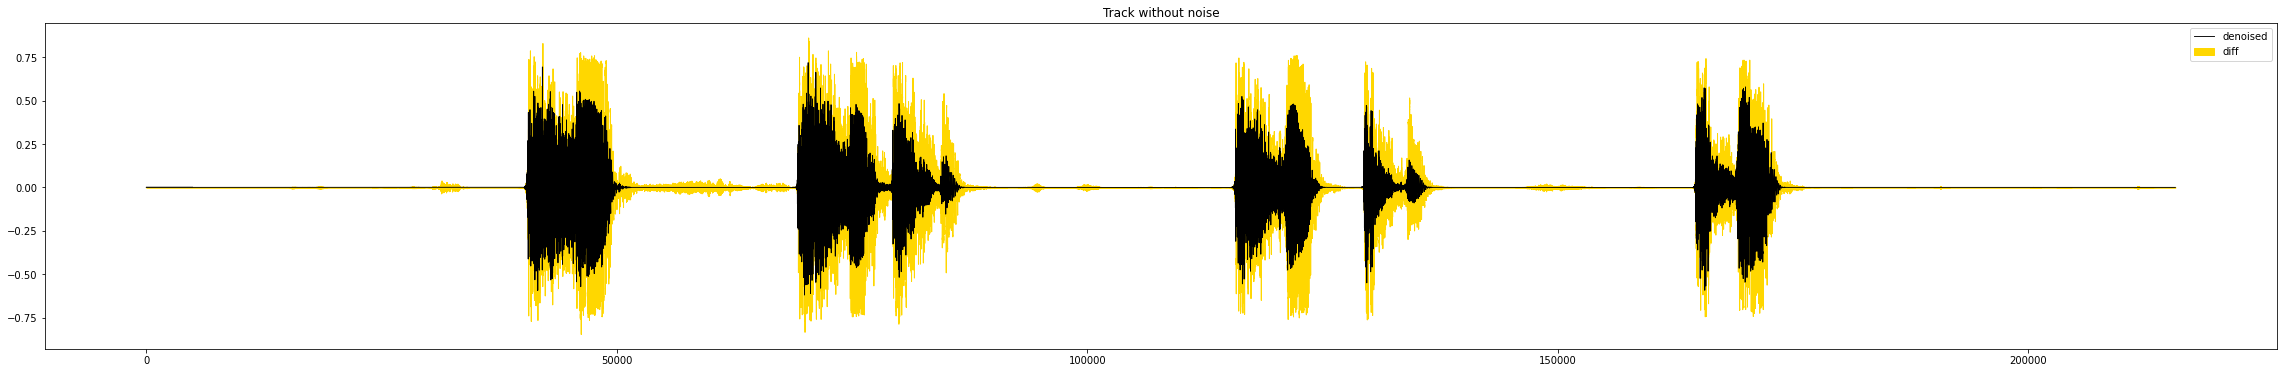

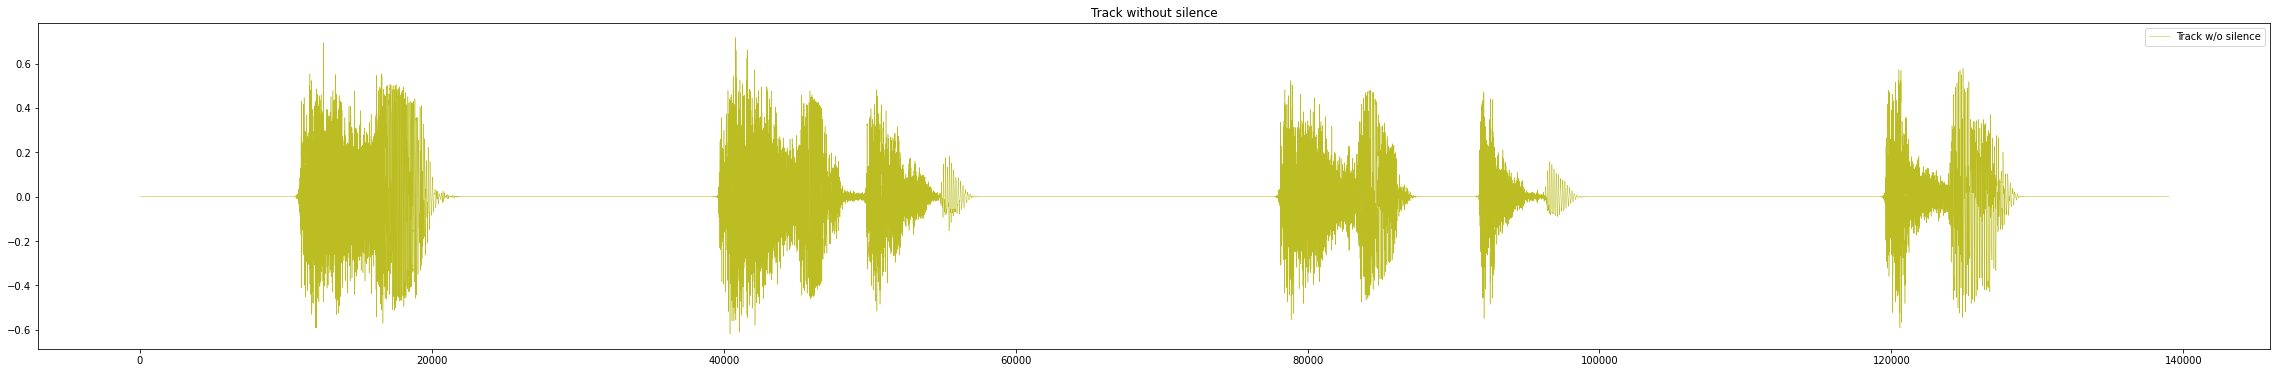

In [12]:
plt.figure(figsize=(40,6))
plt.plot(original_track, color='tab:olive', linewidth=0.5, label = 'Original track')
# plt.hlines(0, 0, 5000,color='black', linewidth=0.7)
plt.title("Original audio track")
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(reduced_noise, color='black', linewidth=0.9, label = 'denoised')
plt.fill_between(np.arange(0, 215649, 1), original_track, reduced_noise, color='gold', label = 'diff')
plt.hlines(0, 0, 5000, color='black', linewidth=0.4)
plt.title("Track without noise")
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(nosilence_track, color='tab:olive', linewidth=0.5, label = 'Track w/o silence')
# plt.hlines(0, 0, 5000, color='black', linewidth=0.7)
plt.title("Track without silence")
plt.legend()
plt.show()


# De-noising

In [ ]:
def noise_remover(inputdir, audio_writedir):
  counter = 0
  for audio in os.listdir(inputdir):
    tmp_readpath = os.path.join(inputdir, audio)
    tmp_audio, tmp_sr = librosa.load(tmp_readpath)
    reduced_noise = nr.reduce_noise(y=tmp_audio, sr=tmp_sr)
    tmp_writepath = os.path.join(audio_writedir, audio)
    sf.write(tmp_writepath, reduced_noise, 22050)                   # Save audio file

    counter += 1
    if counter%1000 == 0:
      print('Done: ' + str(counter) + '/12119')

In [ ]:
inputdir = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioPreprocessedComplete'
outputdir = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoNoise'

In [ ]:
noise_remover(inputdir, outputdir)

Done: 1000/12119
Done: 2000/12119
Done: 3000/12119
Done: 4000/12119
Done: 5000/12119
Done: 6000/12119
Done: 7000/12119
Done: 8000/12119
Done: 9000/12119
Done: 10000/12119
Done: 11000/12119
Done: 12000/12119


# Silence removal

In [ ]:
# Load dataframe for this part
cough_tracks = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Metadata/metadata_coughtracks.csv')
cough_tracks = cough_tracks.drop(['Unnamed: 0'], axis = 1)
cough_tracks.head()

,uuid,cough_detected,age,gender,respiratory_condition,fever_muscle_pain,status
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,0.9609,15.0,male,False,False,healthy
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,0.9301,34.0,male,True,False,healthy
2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,0.9968,21.0,male,False,False,healthy
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,0.8937,28.0,female,False,False,healthy
4,00291cce-36a0-4a29-9e2d-c1d96ca17242,0.9883,15.0,male,False,False,healthy


In [ ]:
# Definition of the list of files and the path where they are saved
all_uuids = cough_tracks['uuid'].values
webmaudio_datadir = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/coughvid_20211012/webm/'
oggaudio_datadir = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/coughvid_20211012/ogg/'
wavaudio_datadir = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/coughvid_20211012/wav/'

In [ ]:
def silence_remover(file_path, file_name, audio_format):
  sound = AudioSegment.from_file(file_path, format = audio_format)  # Load the audiotrack with correct audio format
  audio_chunks = split_on_silence(sound,                            # Splits the audio track based on silence
                                min_silence_len = 1000,             # Remove silence longer than 1s
                                silence_thresh = -45,               # What is below -45 dB is considered silence
                                keep_silence = 500)                 # Keep 0.5s of silence at the beginning/end
  
  combined = AudioSegment.empty()
  for chunk in audio_chunks:  # Putting the file back together
    combined += chunk
  savename = file_name+'.wav'

  # Save the processed file
  combined.export(f'/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoSilence/{savename}', format = 'wav')

In [ ]:
skipped_uuids = []
checklist = [10, 100, 1000, 10000]
counter = 0

# For each file in our dataset, we check its extension so that we can import it correctly. 
# If a file is not processed correctly, we save its name in an external list
for uuid in all_uuids:
  counter += 1
  if counter in checklist:
    print('Processed ' + str(counter) + ' tracks')
  # try to look for a .webm file  
  tmp_audiofilename = webmaudio_datadir+uuid+".webm"
  if not os.path.exists(tmp_audiofilename):
    # try to look for a .ogg file
    tmp_audiofilename = oggaudio_datadir+uuid+".ogg"
    if not os.path.exists(tmp_audiofilename):
      # try to look for a .wav file
      tmp_audiofilename = wavaudio_datadir+uuid+".wav"
      if not os.path.exists(tmp_audiofilename):
        print("WARNING! Could not find audio file for UUID: {}  . Skipping.".format(uuid))
        continue

  file_path = tmp_audiofilename
  file_name = uuid
  audio_format = tmp_audiofilename.split('.')[-1]
  try:
    silence_remover(file_path=file_path, file_name=file_name, audio_format=audio_format)
  except:
    skipped_uuids.append(uuid)
    with open("/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/JSON_Utils/skipped_in_silenceremoval.json", "w") as fp:
      json.dump(skipped_uuids, fp)

Processed 10 tracks
Processed 100 tracks
Processed 1000 tracks


In [ ]:
# Saving skipped uuids
# with open("/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/JSON_Utils/skipped_in_silenceremoval.json", "w") as fp:
#   json.dump(skipped_uuids, fp)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/JSON_Utils/skipped_in_silenceremoval.json', 'rb') as fp:
  skipped_uuids = json.load(fp)

In [ ]:
path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoSilence'
print('Audio after silence removal: ' + str(len(os.listdir(path))))
print('Audio skipped in silence removal: ' + str(len(skipped_uuids)))

Audio after silence removal: 12143
Audio skipped in silence removal: 744


The error obtained for the skipped files is the following:

`CouldntDecodeError: Decoding failed. ffmpeg returned error code: 69`

The issue seems to be that these audio tracks require an .mp4 encoding.

In [ ]:
def silence_remover_mp4(file_path, file_name, audio_format):
  sound = AudioSegment.from_file(file_path, format = audio_format) 
  audio_chunks = split_on_silence(sound,
                                min_silence_len = 1000,
                                silence_thresh = -45,
                                keep_silence = 500)
  combined = AudioSegment.empty()
  for chunk in audio_chunks:
    combined += chunk
  savename = file_name+'.wav'
  combined.export(f'/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/SkippedAudio/{savename}', format = 'wav')

In [ ]:
for uuid in skipped_uuids:
  tmp_audiofilename = webmaudio_datadir+uuid+".webm"
  if not os.path.exists(tmp_audiofilename):
    # try to look for a .ogg file
    tmp_audiofilename = oggaudio_datadir+uuid+".ogg"
    if not os.path.exists(tmp_audiofilename):
      # try to look for a .wav file
      tmp_audiofilename = wavaudio_datadir+uuid+".wav"
      if not os.path.exists(tmp_audiofilename):
        print("WARNING! Could not find audio file for UUID: {}  . Skipping.".format(uuid))
        continue

  file_path = tmp_audiofilename
  file_name = uuid
  audio_format = tmp_audiofilename.split('.')[-1]
  silence_remover_mp4(file_path=file_path, file_name=file_name, audio_format="mp4")

All these skipped uuids correspond to "incorrect" audio: the removal of silence actually only leaves the initial second set as a parameter. They are probably empty audio, so they are ignored from now on.

In [ ]:
# Example
audio_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/coughvid_20211012/wav/fffd1834-6cf2-4782-bb30-04c31b46a1fe.wav'
track, sr = librosa.load(audio_path)
ipd.Audio(track, rate = sr)

#### Organizing metadata

In [ ]:
# Removing rows corresponding to skipped uuids
new_metadata = cough_tracks[~cough_tracks['uuid'].isin(skipped_uuids)]
new_metadata.shape

(12143, 7)

In [ ]:
# Having converted all the files to .wav format, we can add the extension to the uuids
new_metadata['uuid'] = new_metadata['uuid'].astype(str) + '.wav'

# cough_detected is no longer useful
new_metadata = new_metadata.drop(['cough_detected'], axis = 1)

new_metadata.reset_index(inplace=True, drop=True)
new_metadata.head()

,uuid,age,gender,respiratory_condition,fever_muscle_pain,status
0,00039425-7f3a-42aa-ac13-834aaa2b6b92.wav,15.0,male,False,False,healthy
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav,34.0,male,True,False,healthy
2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f.wav,21.0,male,False,False,healthy
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952.wav,28.0,female,False,False,healthy
4,00291cce-36a0-4a29-9e2d-c1d96ca17242.wav,15.0,male,False,False,healthy


The classification problem we want to address is a binary classification problem: positive for COVID19 vs. negative for COVID19. So, the crucial point concerns how to handle audio tracks labeled as ***symptomatic*** (to be emphasized that these are **NEGATIVE** symptomatic). Some papers suggest putting them in the positive class, since in a real case it is less severe to have false positives rather than false negatives, but for our goal we want to be able to distinguish between positive and negative for COVID. Therefore, since symptomatic individuals are not labeled as positive, we decide to place them in the negative class.

In [ ]:
# COVID_BI_1 --> symptomatic as positive class (in case we want to use it)
new_metadata = new_metadata.assign(COVID19_BI_1=np.where(new_metadata['status'] == 'healthy', 'Unlikely', 'Likely'))

# COVID_BI_1 --> symptomatic as negative class
new_metadata = new_metadata.assign(COVID19_BI_2=np.where(new_metadata['status'] == 'COVID-19', 'Positive', 'Negative'))

In [ ]:
new_metadata.head()

,uuid,age,gender,respiratory_condition,fever_muscle_pain,status,COVID19_BI_1,COVID19_BI_2
0,00039425-7f3a-42aa-ac13-834aaa2b6b92.wav,15.0,male,False,False,healthy,Unlikely,Negative
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav,34.0,male,True,False,healthy,Unlikely,Negative
2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f.wav,21.0,male,False,False,healthy,Unlikely,Negative
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952.wav,28.0,female,False,False,healthy,Unlikely,Negative
4,00291cce-36a0-4a29-9e2d-c1d96ca17242.wav,15.0,male,False,False,healthy,Unlikely,Negative


In [ ]:
new_metadata.groupby('COVID19_BI_1').size()

COVID19_BI_1
Likely      2955
Unlikely    9188
dtype: int64

In [ ]:
new_metadata.groupby('COVID19_BI_2').size()

COVID19_BI_2
Negative    11529
Positive      614
dtype: int64

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Metadata/metadata_nosilence.csv', 'w', encoding = 'utf-8-sig') as f:
  new_metadata.to_csv(f)

# Resizing audio tracks

In [ ]:
# Load dataframe for this part
audiotracks = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Metadata/metadata_nosilence.csv')
audiotracks = audiotracks.drop(['Unnamed: 0'], axis = 1)

### Checking audio tracks lenght

We want to check the length of the available audio tracks, to decide on a common length to give each of them, in order to have a uniform representation for each data.

In [ ]:
all_uuids = audiotracks['uuid'].values
audio_datadir = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoSilence/'

In [ ]:
def import_raw_audio(filename, indir, sr=None):
    t, sr = librosa.load(indir+filename, sr=sr, mono=True)
    return t, sr

In [ ]:
audio_duration = []
sampling_rates = []
j = 0

for uuid in all_uuids:
  tmp_audio, sr = import_raw_audio(uuid, indir=audio_datadir)
  duration = tmp_audio.shape[0]/sr
  sampling_rates.append(sr)
  audio_duration.append(duration)
  if j%1000 == 0:
    print('Done '+str(j)+' iterations')
  j=j+1

Done 0 iterations
Done 1000 iterations
Done 2000 iterations
Done 3000 iterations
Done 4000 iterations
Done 5000 iterations
Done 6000 iterations
Done 7000 iterations
Done 8000 iterations
Done 9000 iterations
Done 10000 iterations
Done 11000 iterations
Done 12000 iterations


In [ ]:
# Saving audio durations and sampling rates

# with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/JSON_Utils/audio_durations.json', "w") as fp:
#   json.dump(audio_duration, fp)

# with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/JSON_Utils/sampling_rates.json', "w") as fp:
#   json.dump(sampling_rates, fp)

In [ ]:
# Loading audio durations and sampling rates

with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/JSON_Utils/audio_durations.json', 'rb') as fp:
  audio_duration = json.load(fp)

with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/JSON_Utils/sampling_rates.json', "rb") as fp:
  sampling_rates = json.load(fp)

In [ ]:
print(len(audio_duration))
print(len(sampling_rates))

12143
12143


In [ ]:
sr_results = Counter(sampling_rates)
print(sr_results)

Counter({48000: 12008, 44100: 109, 1: 24, 16000: 2})


Len < 2: 1439
Len < 3: 3461
Len < 4: 5826
Len < 5: 7892
Len < 6: 9468
Len < 7: 10680
Len < 8: 11470
Len < 9: 11941


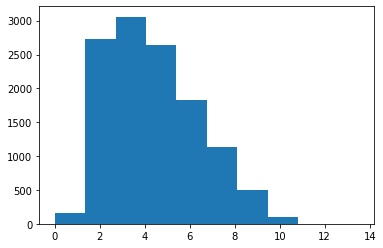

In [ ]:
plt.hist(audio_duration);

print('Len < 2: ' + str(sum([i < 2 for i in audio_duration])))
print('Len < 3: ' + str(sum([i < 3 for i in audio_duration])))
print('Len < 4: ' + str(sum([i < 4 for i in audio_duration])))
print('Len < 5: ' + str(sum([i < 5 for i in audio_duration])))
print('Len < 6: ' + str(sum([i < 6 for i in audio_duration])))
print('Len < 7: ' + str(sum([i < 7 for i in audio_duration])))
print('Len < 8: ' + str(sum([i < 8 for i in audio_duration])))
print('Len < 9: ' + str(sum([i < 9 for i in audio_duration])))

Librosa automatically handles the conversion of the sampling rate (it loads the audio by default at 22050Hz).

For the duration, we have to choose a fixed size. We want to choose a size that keeps the crucial information of the audio tracks but at the same time avoids having an excessive number of scattered values. Since our tracks were previously processed to remove the noise, and considering that the maximum length of the original tracks was approximately 14s (as stated by the authors of the dataset), we can assume that the longest tracks are those with a lot of background noise, where the removal of silence did not have much effect. Therefore, we choose a fixed length of 6 seconds, which appears to be an acceptable trade-off between the two previously mentioned aspects: about 80% of the tracks have a length less than 6s (remembering also that in the removal of noise we kept 0.5 seconds of silence at the end of each track).

In [ ]:
# Example of a long audio track

long_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoSilence/db044a11-1d57-4365-8364-1f73f5fb1bdf.wav'
long_track, long_sr = librosa.load(long_path)
ipd.Audio(long_track, rate = long_sr)

## Resizing all audio tracks

In [ ]:
all_uuids = audiotracks['uuid'].values
audio_datadir = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoSilence/'
audio_writedir = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioPreprocessedComplete/'

In [ ]:
def standardize_lenght(filelist, audio_datadir, audio_writedir, lenght, skip_list):
  counter = 0
  for uuid in filelist:
    tmp_path = audio_datadir+uuid
    tmp_writepath = audio_writedir+uuid

    try:
      tmp_audio, tmp_sr = librosa.load(tmp_path)                  # By default loads audio at a 22050Hz
      tmp_audio = librosa.util.fix_length(tmp_audio, size=lenght) # Fix desired length
      sf.write(tmp_writepath, tmp_audio, 22050)                   # Save audio file
    except:
      skip_list.append(uuid)

    counter += 1
    if counter%1000 == 0:
      print('Done: ' + str(counter) + '/' + str(len(filelist)))

In [ ]:
skipped_in_std = [] # Skipped uuids in length standardization

standardize_lenght(all_uuids, audio_datadir, audio_writedir, 132300, skipped_in_std) # 132300 = 6 seconds

Done: 1000/12143
Done: 2000/12143
Done: 3000/12143
Done: 4000/12143
Done: 5000/12143
Done: 6000/12143
Done: 7000/12143
Done: 8000/12143
Done: 9000/12143
Done: 10000/12143
Done: 11000/12143
Done: 12000/12143


In [ ]:
# with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/JSON_Utils/skipped_in_standardization.json', "w") as fp:
#   json.dump(skipped_in_std, fp)

In [ ]:
# Loading skipped_in_std

with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/JSON_Utils/skipped_in_standardization.json', 'rb') as fp:
  skipped_in_std = json.load(fp)

In [ ]:
len(skipped_in_std)

24

The skipped audio in the standardization are those with a sampling rate of 1, which can't be converted to 22050Hz.

## Re-organizing metadata

In [ ]:
metadata_final = audiotracks[~audiotracks['uuid'].isin(skipped_in_std)]
metadata_final.reset_index(inplace=True, drop=True)
print(metadata_final.shape)

(12119, 8)


In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Metadata/metadata[FINAL].csv', 'w',
          encoding = 'utf-8-sig') as f:
          metadata_final.to_csv(f)